## **Credit card fraud detection dataset**

The aim of this project is to find the best model for identifying CC fraud

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import files
uploaded = files.upload()

import io
dfx = pd.read_csv(io.BytesIO(uploaded['creditcard.csv']))

Saving creditcard.csv to creditcard (1).csv


In [126]:
df = dfx.copy()

In [163]:
# % pip install catboost
# % pip install lightgbm

In [127]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Transforming data

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.5, 1.0, 'Log data')

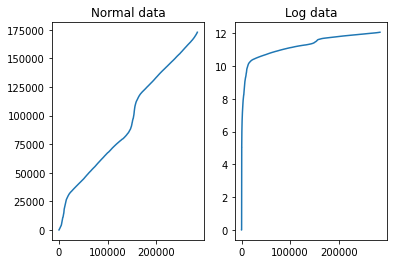

In [128]:
#Trying to make better use of "Time" data using log transformation

fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(df['Time'])
ax1.set_title('Normal data')
ax2.plot(np.log(df['Time']))
ax2.set_title('Log data')

In [129]:
df['Time'] = np.log(df['Time'])

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [130]:
# Transforming 'Amount' data to get better modelling results

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

df['Amount'] = scaler.fit_transform(np.array(df['Amount']).reshape(-1,1))

In [131]:
df.index

RangeIndex(start=0, stop=284807, step=1)

In [132]:
df.tail()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
284802,12.059809,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,-0.350151,0
284803,12.059815,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,-0.254117,0
284804,12.059821,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,-0.081839,0
284805,12.059821,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,-0.313249,0
284806,12.059844,-0.533413,-0.189733,0.703337,-0.506271,-0.012546,-0.649617,1.577006,-0.414650,0.486180,-0.915427,-1.040458,-0.031513,-0.188093,-0.084316,0.041333,-0.302620,-0.660377,0.167430,-0.256117,0.382948,0.261057,0.643078,0.376777,0.008797,-0.473649,-0.818267,-0.002415,0.013649,0.514355,0


In [133]:
# Dealing with unbalanced data

xfr = df[df['Class']==1]
xnfr = df[df['Class']==0].sample(n=xfr.shape[0],random_state=22)
data = pd.concat([xfr, xnfr]) 

x = data.iloc[:, :-1]
y = data.iloc[:,-1]


Feature importance

In [134]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression
 
bestfeatures = SelectKBest(k=5, score_func=f_regression)
fit = bestfeatures.fit(x,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(x.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
featureScores.nlargest(30,'Score').set_index('Specs')  #print 10 best features

,Score
Specs,
V14,1266.967245
V4,977.003240
V11,893.357209
V12,839.219408
V10,641.090662
V16,547.320178
V3,476.717868
V17,443.790694
V9,439.763865


In [135]:
# V22 and V23 are least importanf features, so let's drop them

x = x.drop(columns=['V22', 'V23'])



In [136]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True)

Data modelling

this is a classification type of task, therefore let's choose best classification models

In [167]:
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBRFClassifier

In [175]:
models = []

models.append(('CAT', CatBoostClassifier()))
models.append(('SVC', SVC()))
models.append(('SGD', SGDClassifier()))
models.append(('KN', KNeighborsClassifier()))
models.append(('GPC', GaussianProcessClassifier()))
models.append(('DTREE', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('ETR', ExtraTreesClassifier()))
models.append(('ADA', AdaBoostClassifier()))
models.append(('GBC', GradientBoostingClassifier()))
models.append(('LGBM', LGBMClassifier()))
models.append(('XGB', XGBRFClassifier()))
models.append(('LR', LogisticRegression(solver='liblinear')))

In [176]:
from sklearn.model_selection import cross_val_score
 
scoringx = []
names = []
for name, model in models:
  names.append(name)
  score = cross_val_score(model, X_train, y_train, cv=10, scoring='roc_auc')

  scoringx.append(score)
  print(f'{name}: {score.mean()}, {score.std()}')

Streaming output truncated to the last 5000 lines.
17:	learn: 0.5038813	total: 148ms	remaining: 8.06s
18:	learn: 0.4972970	total: 156ms	remaining: 8.03s
19:	learn: 0.4892580	total: 164ms	remaining: 8.02s
20:	learn: 0.4817767	total: 172ms	remaining: 8.01s
21:	learn: 0.4745988	total: 180ms	remaining: 8s
22:	learn: 0.4671564	total: 188ms	remaining: 7.98s
23:	learn: 0.4613661	total: 198ms	remaining: 8.05s
24:	learn: 0.4530887	total: 215ms	remaining: 8.4s
25:	learn: 0.4471969	total: 225ms	remaining: 8.42s
26:	learn: 0.4399518	total: 233ms	remaining: 8.38s
27:	learn: 0.4332383	total: 241ms	remaining: 8.35s
28:	learn: 0.4269414	total: 249ms	remaining: 8.32s
29:	learn: 0.4217962	total: 257ms	remaining: 8.29s
30:	learn: 0.4153787	total: 266ms	remaining: 8.3s
31:	learn: 0.4083009	total: 274ms	remaining: 8.28s
32:	learn: 0.4026070	total: 282ms	remaining: 8.26s
33:	learn: 0.3974900	total: 290ms	remaining: 8.23s
34:	learn: 0.3920237	total: 298ms	remaining: 8.21s
35:	learn: 0.3870510	total: 307ms	re

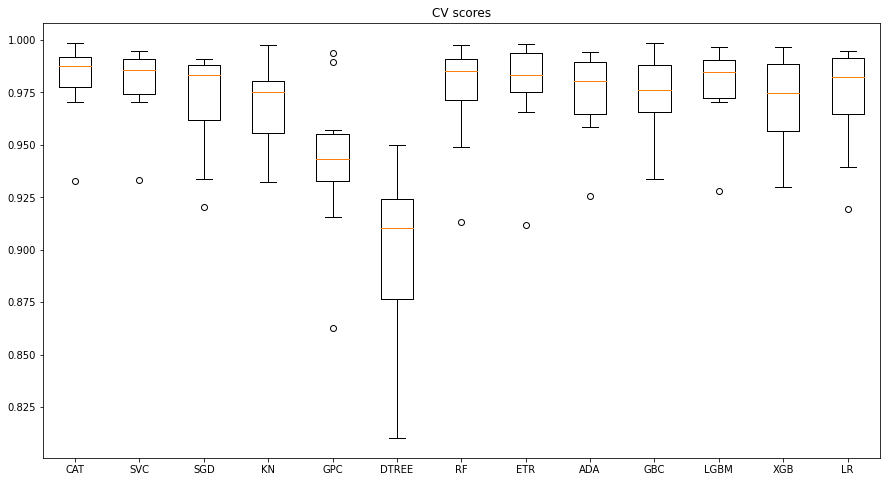

In [177]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.boxplot(scoringx)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
ax.set_title('CV scores')
plt.show()

In [179]:
# All models generalise well, except DTREE. However, best results are shown by Catboost classifier, therefore further we will use it for further evaluation and inference.

Model evaluation - Confusion matrix (we can use it, because we managed to deal with imbalanced dataset)

In [180]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

mod = CatBoostClassifier()

mod = mod.fit(X_train, y_train)

pred = pd.Series(mod.predict(X_test))
print(accuracy_score(y_test, pred))
print(classification_report(y_test, pred))

Learning rate set to 0.009301
0:	learn: 0.6811041	total: 8.64ms	remaining: 8.63s
1:	learn: 0.6670285	total: 16.8ms	remaining: 8.36s
2:	learn: 0.6551545	total: 25.1ms	remaining: 8.33s
3:	learn: 0.6418654	total: 33.4ms	remaining: 8.32s
4:	learn: 0.6286647	total: 41.5ms	remaining: 8.26s
5:	learn: 0.6178050	total: 49.8ms	remaining: 8.25s
6:	learn: 0.6058791	total: 57.9ms	remaining: 8.22s
7:	learn: 0.5937163	total: 74.4ms	remaining: 9.22s
8:	learn: 0.5831512	total: 82.5ms	remaining: 9.08s
9:	learn: 0.5717529	total: 90.2ms	remaining: 8.93s
10:	learn: 0.5605153	total: 98.2ms	remaining: 8.83s
11:	learn: 0.5498177	total: 106ms	remaining: 8.73s
12:	learn: 0.5394762	total: 114ms	remaining: 8.69s
13:	learn: 0.5312396	total: 122ms	remaining: 8.62s
14:	learn: 0.5214244	total: 132ms	remaining: 8.66s
15:	learn: 0.5104500	total: 140ms	remaining: 8.59s
16:	learn: 0.5016258	total: 147ms	remaining: 8.52s
17:	learn: 0.4936947	total: 155ms	remaining: 8.45s
18:	learn: 0.4865235	total: 162ms	remaining: 8.38s


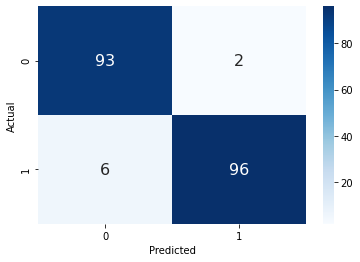

In [181]:
cm = pd.DataFrame(confusion_matrix(y_test, pred), columns = np.unique(y_test), index = np.unique(y_test))
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
sns.heatmap(cm, cmap='Blues', annot=True, annot_kws={'size': 16})

As you can see, model shows very good results ifentifying fraudulent transactions (more important is recall score, which shows that out of 102 transactions 96 were identified correctly as fraudulent, however 6 fraudulent transactions were missed)